**Step 1: Mount Google Drive path**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/My Drive/thesis"
!ls "./"

/content/gdrive/My Drive/thesis
conv_wikidump_txt	 malay_word2vec.ipynb
conv_wikidump_txt_test	 mswiki-latest-pages-articles.xml.bz2
load_dataset.ipynb	 mswiki.model
load_dataset_test.ipynb  mswiki.model.trainables.syn1neg.npy
Malaya-Dataset-master	 mswiki.model.wv.vectors.npy
Malaya-master		 ms-wiki-test.txt
malay_word2vec		 ms-wiki.txt


**Step 2: Define function for loading the corpus**

In [ ]:
#check_corpus is used to print some lines from the .txt input file
import sys, time

def check_corpus(input_file):
  """Reads some lines of corpus from text file"""
  while(1):
    for lines in range(50):
      print(input_file.readline())
    break

In [ ]:
import pandas as pd
import json
import re
from IPython.display import display

#similar to check_corpus but place all text in a pandas dataframe instead
def pandas_corpus(dataset_path):
  title_list = list()
  lines = list()
  d = list()

  with open(dataset_path, encoding='utf-8') as f:
    for line in f:
      lines.append(line.rstrip()) # All lines including the blank ones
      # title_match = re.match(r".*?'''(.*?)'''.*", str(line))
      # if title_match:
      #   title = title_match.group(1)
      # else:
      #   title = "N/A"
      # title_list.append(title)
    #lines = list(line for line in lines if line) # Non-blank lines
    d.append(pd.DataFrame({'title': "N/A", 'article': lines}))
  df = pd.concat(d)
  #print(df)
  display(df)
  #return temp_df

In [ ]:
#load_corpus with processing time display
def load_corpus(input_file):

    """Loads corpus from text file"""

    print('Loading corpus...')
    time1 = time.time()
    corpus = input_file.read()
    time2 = time.time()
    total_time = time2-time1
    print('It took %0.3f seconds to load corpus' %total_time)
    return corpus

Call the functions above to load the corpus

In [ ]:
pandas_corpus("./ms-wiki.txt")              #Converted Wiki Dump (.xml to .txt) obtained from [1] in README.md
corpus_file = open("./ms-wiki.txt",'r')
#check_corpus(corpus_file)
corpus = load_corpus(corpus_file)

,title,article
0,N/A,bahasa melayu tulisan jawi بهاس ملايو ialah se...
1,N/A,fail stilles mineralwasser jpg thumb air miner...
2,N/A,kandungan terbuka dicipta dengan analogi dari ...
3,N/A,khalifah abdul malik bin marwan dilahirkan pad...
4,N/A,penyu adalah daripada superkeluarga chelonioid...
...,...,...
131202,N/A,fail png thumb px layar tradisional suku bangs...
131203,N/A,dalam pelayaran istilah gunter digunakan untuk...
131204,N/A,fail jpg thumb px sandeq di majene sandeq adal...
131205,N/A,jiang chaoliang cina 蒋超良 pinyin jiǎng chāolián...


Loading corpus...
It took 5.983 seconds to load corpus


**Step 3: Word2Vec Training**

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')# ignore warning

import logging
import os.path
import sys
import multiprocessing

from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec

Define LossLogger to check the loss after each epoch

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

loss_list = list()

class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subbed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subbed
        loss_list.append(loss_now)
        self.loss_to_be_subbed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

The training uses Skip-gram model of Word2Vec.
<br>Embedding size is set to 300, similar to English Word2Vec default.
<br>Window size = 5

In [ ]:
def train_word2vec_model():
  loss_list.append(25)
  logger = logging.getLogger("mylog")
  logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s',level=logging.INFO)
  logger.info("running %s" % ' '.join(sys.argv))
  
  inp = "./ms-wiki.txt"
  outp1 = "mswiki.model"
  outp2 = "mswiki.vector"
  
  # train skip-gram model
  model = Word2Vec(LineSentence(inp), iter=5, size=300, window=5, min_count=5, 
                   workers=multiprocessing.cpu_count(), compute_loss=True, callbacks=[LossLogger()])
  
  # save model
  model.save(outp1)
  model.wv.save_word2vec_format(outp2, binary=False)

In [ ]:
train_word2vec_model()

2020-03-02 18:59:20,536: INFO: running /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-00ce88dd-dee1-4923-a6cf-b52ae55fabe7.json
2020-03-02 18:59:20,539: INFO: collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-03-02 18:59:20,573: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-02 18:59:22,298: INFO: PROGRESS: at sentence #10000, processed 5610617 words, keeping 183706 word types
2020-03-02 18:59:23,970: INFO: PROGRESS: at sentence #20000, processed 10469460 words, keeping 295486 word types
2020-03-02 18:59:25,234: INFO: PROGRESS: at sentence #30000, process

Loss after epoch 0: 21949532.0


2020-03-02 19:02:14,279: INFO: EPOCH 2 - PROGRESS: at 0.32% examples, 280207 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:15,285: INFO: EPOCH 2 - PROGRESS: at 0.54% examples, 285289 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:16,290: INFO: EPOCH 2 - PROGRESS: at 0.85% examples, 288155 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:17,318: INFO: EPOCH 2 - PROGRESS: at 1.36% examples, 288882 words/s, in_qsize 2, out_qsize 1
2020-03-02 19:02:18,353: INFO: EPOCH 2 - PROGRESS: at 1.71% examples, 289668 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:19,390: INFO: EPOCH 2 - PROGRESS: at 2.17% examples, 292072 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:20,427: INFO: EPOCH 2 - PROGRESS: at 2.75% examples, 296759 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:21,444: INFO: EPOCH 2 - PROGRESS: at 3.30% examples, 300197 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:02:22,488: INFO: EPOCH 2 - PROGRESS: at 3.96% examples, 300407 words/s, in_qsize 3, out_qsize 0
2020-03-02

Loss after epoch 1: 13873472.0


2020-03-02 19:04:10,003: INFO: EPOCH 3 - PROGRESS: at 0.36% examples, 303567 words/s, in_qsize 4, out_qsize 1
2020-03-02 19:04:11,022: INFO: EPOCH 3 - PROGRESS: at 0.56% examples, 304852 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:12,049: INFO: EPOCH 3 - PROGRESS: at 0.92% examples, 301560 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:13,062: INFO: EPOCH 3 - PROGRESS: at 1.44% examples, 303114 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:14,075: INFO: EPOCH 3 - PROGRESS: at 1.79% examples, 304130 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:15,083: INFO: EPOCH 3 - PROGRESS: at 2.30% examples, 304136 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:16,102: INFO: EPOCH 3 - PROGRESS: at 2.85% examples, 305419 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:17,115: INFO: EPOCH 3 - PROGRESS: at 3.42% examples, 305347 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:04:18,141: INFO: EPOCH 3 - PROGRESS: at 3.98% examples, 304610 words/s, in_qsize 3, out_qsize 0
2020-03-02

Loss after epoch 2: 8968648.0


2020-03-02 19:06:04,220: INFO: EPOCH 4 - PROGRESS: at 0.35% examples, 307596 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:05,229: INFO: EPOCH 4 - PROGRESS: at 0.56% examples, 314046 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:06,240: INFO: EPOCH 4 - PROGRESS: at 0.95% examples, 315351 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:07,287: INFO: EPOCH 4 - PROGRESS: at 1.46% examples, 308496 words/s, in_qsize 2, out_qsize 1
2020-03-02 19:06:08,297: INFO: EPOCH 4 - PROGRESS: at 1.82% examples, 309895 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:09,312: INFO: EPOCH 4 - PROGRESS: at 2.34% examples, 311803 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:10,317: INFO: EPOCH 4 - PROGRESS: at 2.91% examples, 311313 words/s, in_qsize 2, out_qsize 1
2020-03-02 19:06:11,345: INFO: EPOCH 4 - PROGRESS: at 3.55% examples, 310977 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:06:12,348: INFO: EPOCH 4 - PROGRESS: at 4.06% examples, 310416 words/s, in_qsize 3, out_qsize 0
2020-03-02

Loss after epoch 3: 8253628.0


2020-03-02 19:07:58,332: INFO: EPOCH 5 - PROGRESS: at 0.36% examples, 308065 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:07:59,353: INFO: EPOCH 5 - PROGRESS: at 0.57% examples, 317763 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:00,385: INFO: EPOCH 5 - PROGRESS: at 0.99% examples, 318263 words/s, in_qsize 2, out_qsize 1
2020-03-02 19:08:01,404: INFO: EPOCH 5 - PROGRESS: at 1.51% examples, 315516 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:02,427: INFO: EPOCH 5 - PROGRESS: at 1.87% examples, 315011 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:03,435: INFO: EPOCH 5 - PROGRESS: at 2.38% examples, 316891 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:04,440: INFO: EPOCH 5 - PROGRESS: at 2.97% examples, 317622 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:05,463: INFO: EPOCH 5 - PROGRESS: at 3.69% examples, 318167 words/s, in_qsize 3, out_qsize 0
2020-03-02 19:08:06,504: INFO: EPOCH 5 - PROGRESS: at 4.16% examples, 316708 words/s, in_qsize 3, out_qsize 0
2020-03-02

Loss after epoch 4: 7485888.0


2020-03-02 19:09:52,255: INFO: not storing attribute vectors_norm
2020-03-02 19:09:52,261: INFO: storing np array 'syn1neg' to mswiki.model.trainables.syn1neg.npy
2020-03-02 19:09:53,160: INFO: not storing attribute cum_table
2020-03-02 19:09:53,654: INFO: saved mswiki.model
2020-03-02 19:09:53,658: INFO: storing 175214x300 projection weights into mswiki.vector


**Step 4: Plot the loss for Word2Vec Training**

[21949532.0, 13873472.0, 8968648.0, 8253628.0, 7485888.0]


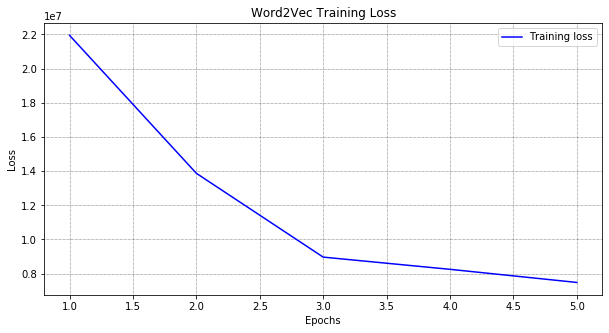

In [ ]:
import matplotlib.pyplot as plt

print (loss_list)
loss = loss_list    #backup list
epochs = range(1, len(loss) + 1)

# "b--" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Word2Vec Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Customize the major grid
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.rcParams['figure.figsize'] = [20, 10]

plt.show()

**Step 5: Load Trained Word2Vec**

In [ ]:
!pip3 install --upgrade gensim --user

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')# ignore error
import gensim
model = gensim.models.Word2Vec.load ("./mswiki.model")

**Step 6: Define Functions for Testing Word2Vec**

In [ ]:
#Print most similar words to the input word
def test_most_similar (input_text):
   word = model.wv.most_similar(input_text)
   for t in word:
        print (t[0],t[1])

#Test the similarity between two input words
def test_similarity (input_text1, input_text2):
   print (model.wv.similarity (input_text1, input_text2))

#Find the least similar word (odd-one-out) among 5 words
def test_doesnt_match (input_text1, input_text2, input_text3, input_text4, input_text5):
    list5 = [input_text1, input_text2, input_text3, input_text4, input_text5]
    print (model.wv.doesnt_match(list5))

a. Try to list the most similar words to see whether if the resutls are sensible

In [ ]:
test_most_similar("basikal")
#word: bicycle
#similars: motorcycle, racing, riders, BMX, racers, cycling etc.

motosikal 0.7236130237579346
motorsikal 0.6834418773651123
lumba 0.6807292103767395
berbasikal 0.6282558441162109
penunggang 0.6212975978851318
gegancu 0.6155469417572021
bmx 0.6085044741630554
menunggang 0.5766348838806152
pelumba 0.5760899186134338
mengayuh 0.5740960240364075


In [ ]:
test_most_similar("sabah")
#word: Sabah (a state in East Malaysia)
#similars: Sarawak (its neighbouring states) and cities/places near Sabah

sarawak 0.7705913782119751
tawau 0.6347787380218506
sandakan 0.634151816368103
kudat 0.5683799982070923
kuching 0.5637481212615967
papar 0.563594400882721
semporna 0.5613182783126831
keningau 0.5437761545181274
penampang 0.5365309715270996
malaysia 0.5328742861747742


b. Check similarity between 2 words. As an example, consider the first case with Perak & Selangor (2 neighbouring states) and the second case with Perak & Sarawak (far from each other)

In [ ]:
test_similarity ("perak","selangor")

0.59728384


In [ ]:
test_similarity ("perak","sarawak")

0.37876657


c. Print odd-one-out between: cup, bowl, plate, pan, elephant. Ideally the animal should be printed out.

In [ ]:
test_doesnt_match("cawan","mangkuk","pinggan","kuali", "gajah")

gajah


/root/.local/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


**Step 7: Visualization after dimensionality reduction**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


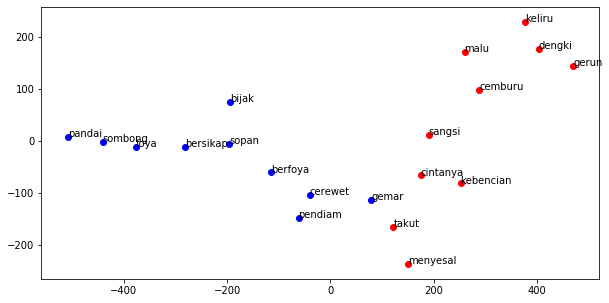

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE

def display_closestwords_tsnescatterplot(model, word, antnm):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]
    antnm_labels = [antnm]

    # get close words
    close_words = model.wv.similar_by_word(word)
    close_words += model.wv.similar_by_word(antnm)
    temp = np.array(model.wv.similar_by_word(antnm))
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=1000)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    
    target_ids = range(len(close_words))
    for i in target_ids:
        if (close_words[i][0] in temp[:,0]):
            plt.scatter(Y[i, 0], Y[i, 1], c='blue')
        else:
            plt.scatter(Y[i, 0], Y[i, 1], c='red')
        plt.annotate(close_words[i][0], xy=(Y[i, 0], Y[i, 1]), xytext=(0, 0), textcoords='offset points')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.show()
    
display_closestwords_tsnescatterplot(model, 'benci', 'suka')

In [ ]:
topics = ['Pengangkutan (Transports)', 'Sukan (Sports)', 'Makanan (Foods)', 'Tumbuhan (Plants)',
        'Haiwan (Animals)', 'Angkasa (Space)', 'Eropah (Europe)', 'Asia (Asia)',
        'Afrika (Africa)', 'Filosofi (Philosophy)', 'Pekerjaan (Professions)']

keys = ['kenderaan', 'sukan', 'makanan', 'tumbuhan',
        'haiwan', 'planet', 'bulgaria', 'thailand',
        'nigeria', 'aristotle', 'jurutera']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

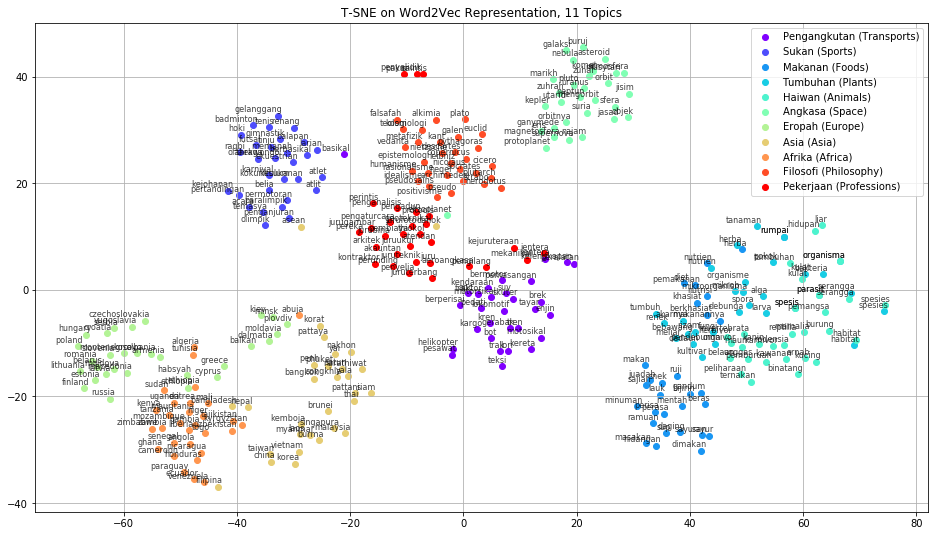

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_2d(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.75, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=1)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_2d('T-SNE on Word2Vec Representation, 11 Topics', topics, embeddings_2d, word_clusters, 1,
                        'word2vec_tsne2d.png')

In [ ]:
embedding_3d_clusters = []
word_3d_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        #word_3d_clusters.append(similar_word)
        embedding_3d_clusters.append(model[similar_word])
        words.append(similar_word)
        # embeddings.append(model[similar_word])
    # embedding_3d_clusters.append(embeddings)
    word_3d_clusters.append(words)

embedding_3d_clusters = np.array(embedding_3d_clusters)
f, g = embedding_3d_clusters.shape
h = len(topics)
j = f//h

tsne_model_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_3d = np.array(tsne_model_3d.fit_transform(embedding_3d_clusters)).reshape(h, j, 3)
# # embeddings_3d = tsne_model_3d.fit_transform(embedding_3d_clusters)
# # embeddings_3d = np.array(tsne_model_3d.fit_transform(embedding_3d_clusters.reshape(f * g, h))).reshape(f, g, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

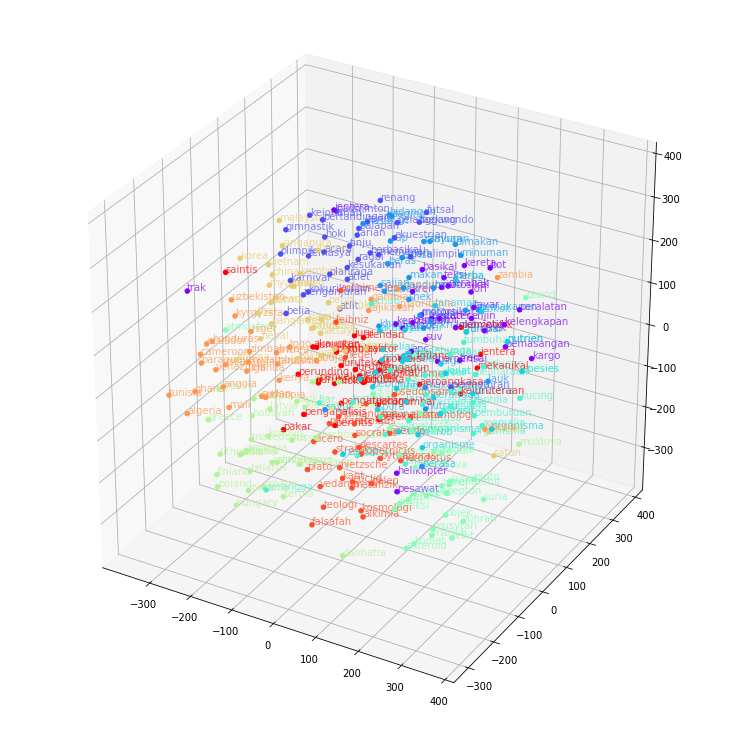

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def tsne_plot_3d(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    #ax = fig.add_subplot(111, projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        z = embeddings[:, 2]
        ax.scatter(x, y, z, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
          ax.text(x[i], y[i], z[i], word, alpha=0.7, c=color)
          # plt.annotate(word, alpha=0.75, xyz=(x[i], y[i], z[i]), xytext=(5, 2),
          #                textcoords='offset points', ha='right', va='bottom', size=8)

    
    #plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi='figure', bbox_inches='tight')
    plt.show()


#tsne_plot_3d('Visualizing Embeddings using t-SNE', topics, embeddings_wp_3d, a=0.1)
tsne_plot_3d(' ', topics, embeddings_3d, word_3d_clusters, 1,
                        'word2vec_tsne3d.png')